In [35]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model="gpt-4o-mini")

result=llm.invoke("Hello?")
print(result.content)

Hello! How can I assist you today?


In [36]:
###Custom Tools


#Always give the docstring as that is going to be read by the LLM
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int,b:int)->int:
    """Add a and b

    Args:
        a:first int
        b:second int
    """
    return a+b

def divide(a:int,b:int)->float:
    """Divide a by b
     
    Args:
        a:first int
        b:second int
    """
    return a/b

tools=[multiply,add,divide]

tools

[<function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.add(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [37]:
##Integrate Tools with LLM
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x12b400410>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x12b400a50>, root_client=<openai.OpenAI object at 0x12b26f390>, root_async_client=<openai.AsyncOpenAI object at 0x12b4007d0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'ty

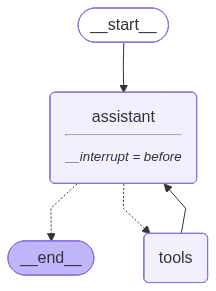

In [ ]:
##Workflow with Langgraph
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,SystemMessage,HumanMessage



sys_msg=SystemMessage(content="You are a helpful assistant tasked with performing arithmetic operations")



#Node definition
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+ state["messages"])]}


##Graph
builder=StateGraph(MessagesState)

##Define Nodes:
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

##Define edges 
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    #If the latest message (result) from assistant is a tool call->tools_condition routes to tool
    #If the latest message (result) from assistant is not a tool call-> tools condition routes to END

    tools_condition,
    )


builder.add_edge("tools","assistant")

memory=MemorySaver()

graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [ ]:
thread={"configurable":{"thread_id":"123"}}

In [40]:
initial_input={'messages':[HumanMessage(content="Multiply 2 and 3")]}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [41]:
state=graph.get_state(thread)
state.next

('assistant',)

In [42]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a54da36e-7248-4721-b53a-1a5a942047a0')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3ecc-9a8b-632e-8000-ecaf5ed87c51'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-28T10:56:42.541535+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3ecc-9a84-6bc8-bfff-9b3eafcc9211'}}, tasks=(PregelTask(id='ae40aab6-4106-f0e2-f626-3e6974cf519f', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [43]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x129e054e0>

In [44]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oQJXfO84J5TClUBMZK9NWxZc)
 Call ID: call_oQJXfO84J5TClUBMZK9NWxZc
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [45]:
state=graph.get_state(thread)
state.next

('assistant',)

In [46]:
#Continue the execution of assistant and then end
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


#Edit the Human FEEDBACK

In [55]:
initial_input={"messages":[HumanMessage(content="Multiply 2 and 3")]}

thread={"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [56]:
state=graph.get_state(thread)
state.next

('assistant',)

In [57]:
graph.update_state(thread,{"messages":[HumanMessage(content="No,Please multiply 15 and 6")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3eea-c56d-6204-8001-40ef00d24c3d'}}

In [58]:
new_state=graph.get_state(thread).values

for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,Please multiply 15 and 6


In [ ]:

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No,Please multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_UPYb72jZLOkbloYzb6wC6EH5)
 Call ID: call_UPYb72jZLOkbloYzb6wC6EH5
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [63]:

for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

The result of multiplying 15 and 6 is 90.


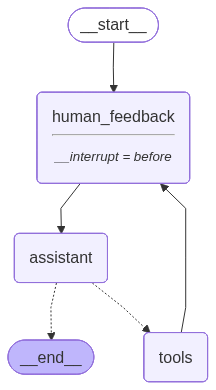

In [65]:
#Workflow will wait for user input
#Workflow will wait for user input
sys_msg=SystemMessage(content="You are a helpful assistant that can perform arithmetic operations")

##Human feedback Node

def human_feedback(state:MessagesState):
      pass


##Assistant Node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}


builder=StateGraph(MessagesState)

#Add Node
builder.add_node("assistant",assistant)
builder.add_node("human_feedback",human_feedback)
builder.add_node("tools",ToolNode(tools))


#Add Edge
builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,

)

builder.add_edge("tools","human_feedback")

memory=MemorySaver()

graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [71]:
#Input
initial_input={"messages":[HumanMessage(content="Multiply 2 and 3 ")]}


#Thread
thread={"configurable":{"thread_id":"5"}}

#Run the graph until the first interruption
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()



#GET USER INPUT
user_input=input("Tel me how do you want to update the state")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()




================================ Human Message =================================

Multiply 2 and 3 
================================ Human Message =================================

Please update the numbers with 5 and 15
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Tbx6yofRylAOUTc7pA3Y79nD)
 Call ID: call_Tbx6yofRylAOUTc7pA3Y79nD
  Args:
    a: 5
    b: 15
================================= Tool Message =================================
Name: multiply

75
